# Lecture 23 (5/18/2022)

**Announcements**


*Last time we covered:*
- Clustering: $k$-means

**Today's agenda:**
- Evaluating $k$-means and other clustering solutions


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluating $k$-means (and other clustering) algorithms

Ways $k$-means clustering can fail, and how to overcome them:

1. Wrong number of clusters
    - Using WCSS and the "elbow method" to determine clusters
2. Inconsistent (and sometimes sub-optimal) clusters
    - Repeated iterations; k-means++ and other variants
3. Consistently sub-optimal clusters
    - The underlying "model" of $k$-means (mouse data)

Instead of the `iris` dataset that we used last time, let's check out some of the sklearn tools for *generating* sample data: the sklearn `make_blobs` function [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) (see other available data generators [here](https://scikit-learn.org/stable/modules/classes.html#samples-generator))

**Step 1: generate our data**

In [2]:
from sklearn.datasets import make_blobs

sample_vals, sample_clusters = make_blobs(n_samples = 300, # how many samples to generate 
                                          n_features = 2, # number of features
                                          centers = 3, # how many "blobs"
                                          center_box = (0, 10), # what range the "centers" can be in
                                          cluster_std = 1, # SD of the blobs (can be a list)
                                          random_state = 1
                                         )

# sample_vals
# sample_clusters

**Step 2: let's take a look!**

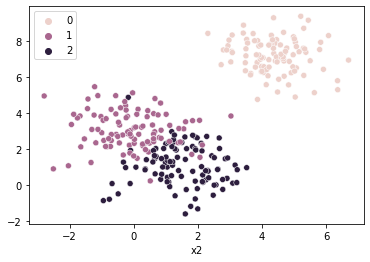

In [3]:
sns.scatterplot(x = sample_vals[:, 0], y = sample_vals[:, 1], hue = sample_clusters)
plt.xlabel("x1")
plt.xlabel("x2")
plt.show()

**Step 3: profit**

![leo](img/leo.gif)

***

## Ensuring the right number of clusters

How do we know when a clustering algorithm like $k$-means has generated the "right" number of clusters?

One solution that we've relied on for simple data like the above is to just look at the clustering solution. Do the assigned clusters *look right*? 

But this isn't always an option. What do we do for example when our data is multi-dimensional and we can't easily visualize it?

...

### Goldilocks and the Three Clusters

Let's start by just thinking about what having the right number of clusters should look like:
- When our data is easily clustered and we've properly assigned it to the right clusters, every point should be relatively close to the center of its respective cluster (ideally)
- When our data is easily clustered but we've assigned it to too *few* clusters, some of our data points will be far from the cluster's center
- When our data is easily clustered but we've assigned it to too *many* clusters, our points will all be pretty close the center of their respective clusters, but maybe not that much better than when we had the right amount because at that point we're just splitting up existing clusters

Let's see an example of this with our data above:

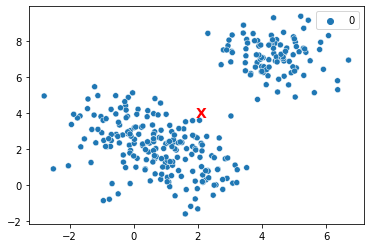

In [4]:
from sklearn.cluster import KMeans

# Too FEW clusters
km1 = KMeans(n_clusters = 1, random_state = 1).fit(X = sample_vals)

sns.scatterplot(x = sample_vals[:, 0], y = sample_vals[:, 1], hue = km1.labels_)
plt.text(x = km1.cluster_centers_[0, 0], y = km1.cluster_centers_[0, 1], 
         s = "X", fontweight = "bold", fontsize = 14, color = "red")
plt.show()

In the above, some of these points are much farther away from the center of their assigned cluster (in X) than they would be if we properly assigned them to 2-3 *separate* clusters.

*What about when there are too many clusters?*

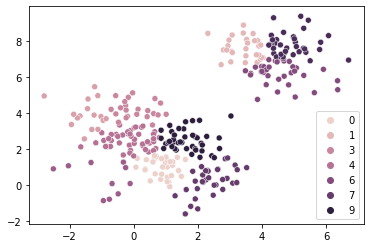

In [5]:
from sklearn.cluster import KMeans

# Too MANY clusters
km10 = KMeans(n_clusters = 10, random_state = 1).fit(X = sample_vals)

sns.scatterplot(x = sample_vals[:, 0], y = sample_vals[:, 1], hue = km10.labels_)
plt.show()

Now, each of these points will be super close to their center, but not that much closer than they would be with just 2-3 cluster centers.

Take a look at 3 clusters below to get a sense of this:

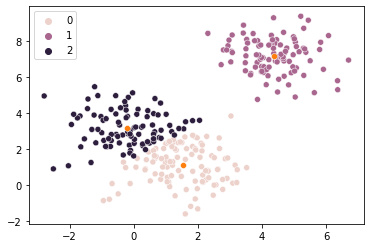

In [6]:
# This k-means is juuuust right
km3 = KMeans(n_clusters = 3, random_state = 1).fit(X = sample_vals)
sns.scatterplot(x = sample_vals[:, 0], y = sample_vals[:, 1], 
                hue = km3.labels_
               )
sns.scatterplot(x = km3.cluster_centers_[:, 0], y = km3.cluster_centers_[:, 1]) 
plt.show()

So, a metric that captures how close each data point is to the center of its assigned cluster might give us a way to estimate the right number of clusters based on these intuitions.

### $k$-means *Inertia* or Within-Cluster Sum of Squares (WCSS)

The *inertia* metric for our $k$-means clusters tells us how close each data point is to its respective cluster center. 

$\text{inertia} = \sum_{i=1}^{N} {(x_i - C_k)}^2$ where $C_k$ is the *center* of each data point's assigned cluster.

Inertia is essentially a measure of the *variance* of our clusters (though it scales with the number of data points).

Our sklearn $k$-means model tells us the inertia for the clusters it estimated. 

*How do our inertia values compare for the models above?*

In [7]:
print("1 cluster: {}".format(km1.inertia_)) # super high when we only assign 1 cluster
print("10 clusters: {}".format(km10.inertia_)) # MUCH lower when we assign 10 clusters
print("3 clusters: {}".format(km3.inertia_)) # What about when we assign 3 clusters?
# this is definitely higher than for k = 10, but not THAT much higher...

1 cluster: 3553.2877803096735
10 clusters: 194.76095710197015
3 clusters: 541.4034319875432


The better way to see this pattern is to graph our inertia for increasing numbers of $k$-means clusters:

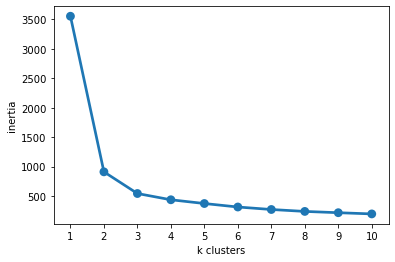

In [8]:
# Here's a fun list comprehension!
inertias = [KMeans(n_clusters = k, random_state = 1).fit(X = sample_vals).inertia_ for k in np.arange(1, 11)]
inertias

sns.pointplot(x = np.arange(1, 11), y = inertias)
plt.xlabel("k clusters")
plt.ylabel("inertia")
plt.show()

In [9]:
km3.cluster_centers_

array([[ 1.52672439,  1.09826024],
       [ 4.37662326,  7.20432474],
       [-0.21045907,  3.18789892]])

### The "Elbow Method"

One strategy for identifying the right number of clusters in your data is the "elbow method" (I'm not making this up...), which involves identifying the point in the curve above where the line starts to flatten (i.e., the *elbow*).

So in this case, we end up with an optimal number of clusters around 2-3 (which matches our data above pretty well).

You can read a nice overview of this approach [here](https://towardsdatascience.com/clustering-how-to-find-hyperparameters-using-inertia-b0343c6fe819).

If this feels a bit weirdly subjective, it's because it is... There are other approaches available but none is a silver bullet; you can read more about them on the wikipedia page [here](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set). Some are much more complex and some are specific to particular classes of clustering models. Other clustering models don't require you to specify the number of clusters *at all*, but almost all of them have *some* hyperparameter that requires a bit of tuning or intuition. 

***

## Ensuring optimal (and stable) clustering

Okay, so you've chosen an optimal number of clusters using something like the elbow method. 

Another important question to ask is whether the cluster assignments that $k$-means produces (and the corresponding *inertia* value) are *stable*. In other words, will $k$-means always converge to the same clusters for a given $k$ value?

It turns out, **$k$-means guarantees convergence, but it doesn't guarantee that it will converge to the *global minimum* inertia for a given $k$ value**.

![padme](img/padme.jpeg)

**Why doesn't $k$-means choose the best cluster allocation every time?**

One of the requirements for $k$-means is that you start out with a random set of points as the assigned cluster centers. Which points you choose at the outset can lead to different clustering solutions once the algorithm converges. 

Here's a really clear illustration of this from the $k$-means wikipedia page ([link](https://en.wikipedia.org/wiki/K-means_clustering)):

![km_convergence](img/km_convergence.png)

In the example above, we can see a $k$-means *starting state* with four randomly chosen cluster centers on the far left, and then the cluster assignments it converges to at the far right, which obviously doesn't match how this data naturally clusters.

*So what can we do about this?*

### Solution 1: try again...

Following our intuition in the previous section about the relationship between inertia and proper cluster alignment, it seems like the **bad solution** above (far right) would have much higher inertia than the proper cluster assignment, since the red cluster above is pretty spread out. 

So, one solution to avoid this problem is to **run the $k$-means algorithm repeatedly** with different random initial states, then choose the *best clustering solution* (i.e., lowest inertia) from among those runs.

**Repeated runs in python**

In fact, this is actually what sklearn does when you run `KMeans.fit`! 

By default, it runs the algorithm 10 times and then chooses the best one. 

You can toggle the number of runs with the `n_init` argument at initialization. 

Let's take a look at what happens when we run the algorithm a bunch of times with only *one* convergence per run.

In [10]:
# First, let's run 100 versions of k means with only ONE convergence per run (instead of default 10)
# Another sneaky list comiprehension. Note the `n_init` argument below!
inertias = [KMeans(n_clusters = 3, 
                   n_init = 1 # NOTE
                  ).fit(X = sample_vals).inertia_ for k in np.arange(1, 101)]
inertias

# Now, let's run a single k means with the default 10 convergences and compare them
optim = KMeans(n_clusters = 3).fit(X = sample_vals).inertia_
optim

541.4034319875432

*What do these look like?*

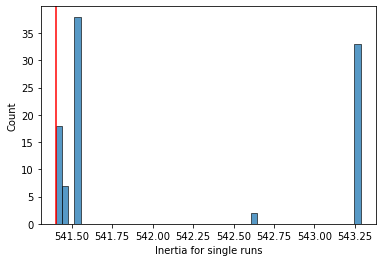

In [11]:
inertias = np.sort(inertias)
inertias # whoa, look at those max values...

inertias = inertias[inertias < 600]
inertias

sns.histplot(x = inertias,
             bins = 50
            )
plt.axvline(optim, c = "r") # add a line showing inertia for our single k means with 10 runs
plt.xlabel("Inertia for single runs")
plt.show()

As you can see above (at least for our pretty clusterable data), running the algorithm 10 times and choosing the best run does a pretty good job identifying the optimal solution.

### Solution 2: $k$-means++

As the name implies, the *$k$-means++* algorithm represents a careful improvement over the *default* $k$-means aimed at optimizing the convergence of the algorithm. 

*What does it do differently?*

Since the default $k$-means runs into issues because of its random assignment of initial cluster centers, one solution is to try and pick more strategic initial clusters at the outset. This is what $k$-means++ does.

Specifically, it chooses a *single first cluster center* at random. Then, it computes every other point's distance from that initial starting point, and chooses a second cluster centroid with a probability proportional to each point's distance from the first centroid. It continues doing this for each point's distance to the *closest* centroid chosen so far. These details aren't super important: what matters is that **$k$-means++ will almost always choose starting centers that are far away from each other**. This helps avoid the problems of local minima shown above.

The $k$-means++ algorithm has a provable upper bound on the inertia of the eventual clusters.

**$k$-means++ in python**

Because $k$-means++ offers such an improvement over the random method, the sklearn `KMeans` class also uses this by default! 

The `init` argument to the `KMeans` class lets you try out alternatives (including passing in explicit points that you want to start as the centroids). 

Let's compare "random" and "kmeans++" for single-run $k$-means clusters to see the difference:

<AxesSubplot:xlabel='method', ylabel='inertia'>

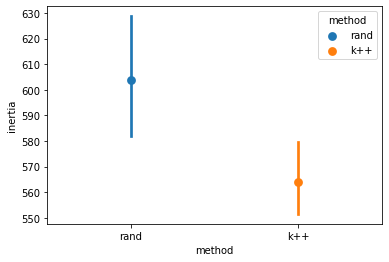

In [12]:
# Run 100 k-means with "random" starting seeds
inertias_rand = np.sort([KMeans(n_clusters = 3, 
                                n_init = 1, 
                                init = "random" # NOTE
                               ).fit(X = sample_vals).inertia_ for k in np.arange(1, 101)])

# Run 100 k-means with "k-means++" starting seeds (the default)
inertias_kplus = np.sort([KMeans(n_clusters = 3, 
                                 n_init = 1, 
#                                  init = "k-means++" # NOTE
                                ).fit(X = sample_vals).inertia_ for k in np.arange(1, 101)])

# Plot the average of the above
inertias_df = pd.concat([
    pd.DataFrame({"method": "rand", "inertia": inertias_rand}),
    pd.DataFrame({"method": "k++", "inertia": inertias_kplus}),
])
sns.pointplot(data = inertias_df, x = "method", y = "inertia", hue = "method")

Above, you can see the impact of using $k$-means++ for initial "seed" selection.

Even though the impact isn't huge here, this can make a big difference with large and complex datasets. 

***

## Consistently sub-optimal clusters

In the previous sections, we discussed how to identify the right number of clusters for our $k$-means algorithm and how to ensure that the clusters it identifies are stable and reasonably optimal. 

However, **there are some scenarios where $k$-means will *reliably* fail to cluster in the ways we want**. 

Here's an intuitive example:

In [13]:
mouse_vals, mouse_clusters = make_blobs(n_samples = [1000, 500, 500], # how many samples to generate 
                                          n_features = 2, # number of features
                                          centers = [(3, 3), (1.5, 5), (4.5, 5)], # how many "blobs"
                                          cluster_std = [.75, .25, .25], # SD of the blobs (can be a list)
                                          random_state = 1
                                         )
mouse_vals

array([[3.37140849, 2.86897263],
       [4.51083011, 4.78849811],
       [3.91886689, 2.20984044],
       ...,
       [1.37955591, 4.90772202],
       [1.51874336, 5.3680004 ],
       [4.39407956, 5.48043454]])

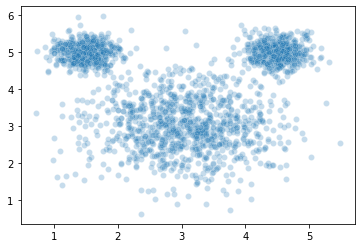

In [14]:
sns.scatterplot(x = mouse_vals[:, 0], 
                y = mouse_vals[:, 1], 
#                 hue = mouse_clusters, # toggle comment this
                alpha = 0.25
               )
plt.show()

The wikipedia page for $k$-means illustrates a similar example and calls the data set "mouse" (can you guess why??), so we'll do the same here.

![mickey](img/mickey.png)

Now, let's see what happens when we estimate clusters in this data using $k$-means:

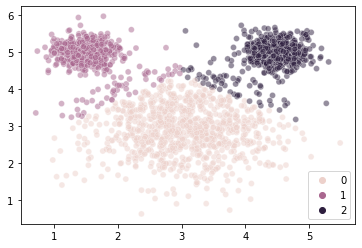

In [15]:
kmouse = KMeans(n_clusters = 3, random_state = 1).fit(X = mouse_vals)

sns.scatterplot(x = mouse_vals[:, 0], 
                y = mouse_vals[:, 1], 
                hue = kmouse.labels_,
                alpha = 0.5
               )
plt.show()

That seems odd... 

*What's happening here?*

...

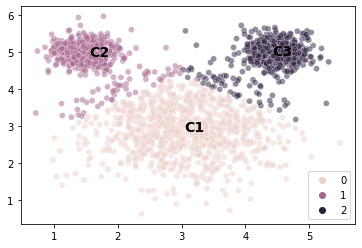

In [16]:
# Let's take a look at the centroids to get a clearer idea

sns.scatterplot(x = mouse_vals[:, 0], 
                y = mouse_vals[:, 1], 
                hue = kmouse.labels_,
                alpha = 0.5
               )
plt.text(x = kmouse.cluster_centers_[0, 0], y = kmouse.cluster_centers_[0, 1], 
         s = "C1", fontweight = "bold", fontsize = 14)
plt.text(x = kmouse.cluster_centers_[1, 0], y = kmouse.cluster_centers_[1, 1], 
         s = "C2", fontweight = "bold", fontsize = 14)
plt.text(x = kmouse.cluster_centers_[2, 0], y = kmouse.cluster_centers_[2, 1], 
         s = "C3", fontweight = "bold", fontsize = 14)
plt.show()

### Choosing the model to fit the data

The mouse example illustrates a really imporant point about evaluating models. 

**Every model makes certain assumptions about the *generative process* for the data it's trying to capture.** 

These assumptions or constraints are, in part, what allow the model to make sense of the world; they *simplify* our description of what's going on. 

> "All models are wrong, but some are useful" ~ George Box (a statistician)

You've already seen this in a previous problem set: simple linear regression assumes that the relationship between two variables will produce *normally distributed residuals* around the line that gets fit. Multiple regression assumes that the predictors aren't correlated. 

Sometimes these assumptions aren't stated explicitly but the mechanics of the model require them. With $k$-means clustering, the model will converge to centroids that (roughly) minimize each point's distance to the nearest centroid. **This process therefore assumes that all of the clusters are the same size.**

***

*So what do we do when a model's assumptions are violated?*
- If you think that the *real world process that generated your data* aligns with the model's assumptions, or that  this is a useful simplification to your real world data, then it's probably okay. 
    - For example, your residuals in a linear regression may never be perfectly normally distributed.
- On the other hand, if you think the process that generated your data is more fundamentally at odds with the model's assumptions, then you probably need a different model. 
    - The data above is a good example of a scenario where $k$-means is probably the wrong model because our clusters have *very* different variances and we want our cluster solutions to reflect that.
    
***

*So what do we use instead?*

There are a **lot** of different clustering solutions out there; like classification, we could probably have a whole quarter devoted just to clustering. 
- The sklearn package has classes for many of the most common ones. You can see the full list [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster)

We're not going to go through the other solutions out there (there are many, and they're each complex in their own way so we would need a lot more time to cover them). 

However, on Friday we're going to talk about one other solution that is important to be familiar with: **Gaussian mixture models**.
- These are a *generalization* of the $k$-means
- They solve the mouse problem we ran into above
- And, they give us an opportunity to discuss *Expectation Maximization*, an important concept in model fitting.

If you'd like to learn more about these and other solutions, there's a really clear and interesting tutorial about the different sklearn clustering algorithms [here](https://scikit-learn.org/stable/modules/clustering.html#clustering). 

![clusters](img/clusters.png)